In [2]:
import os

import numpy as np
import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils import data
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from torchmetrics.clustering import CompletenessScore
from torchmetrics import Accuracy
import wandb
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
import hydra
from omegaconf import DictConfig, OmegaConf
# import ray

from helpers.model import CrowdNetwork2, CrowdNetworkIndep, ResNet9, ResNet34
from helpers.data_load import Cifar10Dataset, cifar10_test_dataset
from helpers.transformer import transform_train, transform_test, transform_target
from helpers.functions import generate_confusion_matrices2
from cluster_acc_metric import MyClusterAccuracy
from my_dataset import CIFAR10DataModule, CIFAR10ShahanaModule, LitCIFAR10N
from utils import plot_confusion_matrix, plot_distribution, turn_off_grad
import constants


class MyModel(nn.Module):
    def __init__(self, K, M, N):
        super().__init__()
        self.f = ResNet34(K)
        # self.f = ResNet9(K)

        P0 = torch.stack([torch.eye(K) for _ in range(M)])
        self.P0 = nn.Parameter(P0)
        self.P0_normalize = nn.Softmax(dim=1)

        e = torch.zeros(N, M, K)
        self.E = nn.Parameter(e)
        self.E_normalize = lambda x: x - x.mean(-1, keepdim=True)

    def forward(self, X, i):
        # (M, K, K)
        f_x, _ = self.f(X)
        P0 = self.P0_normalize(self.P0)
        y = torch.einsum('mkj,bj -> bmk', P0, f_x)
        e = self.E_normalize(self.E[i])
        y = y + e

        # HACKING
        y[y<1e-8] = 1e-8
        y[y>1-1e-8] = 1-1e-8
        y = y/y.sum(-1, keepdim=True)

        return y, e

    def get_e(self):
        return self.E_normalize(self.E)
        # return torch.zeros(47500, 3, 10)

    def pred_cls(self, X):
        y, _ = self.f(X)
        return y


class LitMyModule(L.LightningModule):
    def __init__(self, N, M, K, lr, lam1, lam2, conf):
        super().__init__()
        self.lr = lr
        self.K = K
        self.M = M
        self.N = N
        self.lam1 = lam1
        self.lam2 = lam2

        self.model = MyModel(K, M, N)
        self.loss = nn.NLLLoss(ignore_index=-1)
        self.cluster_acc_metric = MyClusterAccuracy(10)
        self.accuracy_metric = Accuracy(task='multiclass', num_classes=10)

        self.conf = conf

        # self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        batch_x, batch_annotations, inds, indep_mark = batch
        assert batch_annotations.shape[1] == self.M

        Af_x, e = self.model(batch_x.float(), inds)
        Af_x = Af_x.reshape(-1, self.K)
        batch_annotations_mod = batch_annotations.view(-1)
        cross_entropy_loss = self.loss(Af_x.log(), batch_annotations_mod.long())
        if cross_entropy_loss > 100:
            cross_entropy_loss = torch.Tensor(0.)

        # HH = torch.mm(f_x.t(), f_x)
        # logdet = torch.log(torch.linalg.det(HH))
        # loss = cross_entropy_loss - self.lam * regularizer_loss
        logdet = 0.0

        err = self.model.get_e()
        err = err[inds]

        err = (err**2).sum((1, 2)) + 1e-6
        e = (err**0.2).sum()/err.shape[0]

        loss = cross_entropy_loss - self.lam1*logdet + self.lam2*e

        true_ratio = 0.3
        threshold, _ = torch.topk(err, int(0.3*err.shape[0]), sorted=True)
        threshold = threshold[-1]
        outlier_pred = (err < threshold)*1.0
        outlier_pred_acc = ((outlier_pred == indep_mark)*1.).mean()

        outlier_pred_acc2 = (~outlier_pred[~indep_mark.bool()].bool()).float().mean()
        self.log_dict({'ce_loss': cross_entropy_loss, 'logdet': logdet, 'sparse_loss': e, 'loss': loss, 'outlier_pred_acc': outlier_pred_acc, 'outlier_pred_acc2': outlier_pred_acc2})

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch

        pred = self.model.pred_cls(X)
        pred = torch.argmax(pred, 1)
        self.cluster_acc_metric.update(preds=pred, target=y)
        self.accuracy_metric.update(preds=pred, target=y)
        self.log("valid/cluster_acc", self.cluster_acc_metric, on_step=False, on_epoch=True)
        self.log("valid/acc", self.accuracy_metric, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        X, y = batch

        pred = self.model.pred_cls(X)
        pred = torch.argmax(pred, 1)
        self.cluster_acc_metric.update(preds=pred, target=y)
        self.accuracy_metric.update(preds=pred, target=y)
        self.log("test/cluster_acc", self.cluster_acc_metric, on_step=False, on_epoch=True)
        self.log("test/acc", self.accuracy_metric, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer_f = optim.Adam([
            {'params': self.model.f.parameters(), 'lr': self.lr},
            {'params': self.model.P0, 'lr' : 1e-2},
            {'params': self.model.E, 'lr' : 1e-2},
            ], lr=self.lr, weight_decay=1e-4)
        scheduler_f = optim.lr_scheduler.OneCycleLR(optimizer_f, self.lr,
                epochs=self.conf.train.num_epochs,
                steps_per_epoch=int(self.N/self.conf.train.batch_size))
        return [optimizer_f], [scheduler_f]

    def on_train_epoch_start(self):
        if self.current_epoch % 10 == 0:
            with torch.no_grad():
                A0 = self.model.P0_normalize(self.model.P0).cpu().numpy()
                fig = plot_confusion_matrix(A0)
                self.logger.experiment.log({"A0": fig})
                plt.close(fig)

                err = self.model.get_e()
                err = (err**2).sum((1, 2)) + 1e-10
                e = (err**0.2)
                fig = plot_distribution(e, 'error')
                self.logger.experiment.log({'error': fig})

/scratch/tri/venvs/pytorch12/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [3]:
from hydra import compose, initialize
from omegaconf import OmegaConf



In [4]:
with initialize(version_base=None, config_path="conf", job_name="config"):
    conf = compose(config_name="config")

print(OmegaConf.to_yaml(conf))

data:
  'N': 50000
  M: 3
  K: 10
  dataset: cifar10n
train:
  lr: 0.01
  batch_size: 512
  lam1: 0
  lam2: 0.01
  num_epochs: 200



In [ ]:
# model = LitMyModule(conf.data.N, conf.data.M, conf.data.K, conf.train.lr, conf.train.lam1, conf.train.lam2, conf)

In [23]:
best_model_path = '/scratch/tri/shahana_outlier/lightning_saved_models/ethereal-sea-263/syn-epoch=148-global_step=0.ckpt'
model = LitMyModule.load_from_checkpoint(best_model_path, N=conf.data.N, M=conf.data.M, K=conf.data.K, lr=conf.train.lr, 
                                         lam1=conf.train.lam1, lam2=conf.train.lam2, conf=conf)

In [5]:
data_module = LitCIFAR10N(conf.train.batch_size)
data_module.prepare()
data_module.setup('pred')

/scratch/tri/venvs/pytorch12/lib/python3.8/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Done SETTING data module for CIFAR10-N!


In [24]:
E = model.model.get_e()

In [25]:
err = (E**2).sum((1, 2))

In [30]:
v, inds = torch.topk(err, 512)
inds = inds.detach().cpu().numpy()

In [8]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

In [9]:
to_image = ToPILImage()

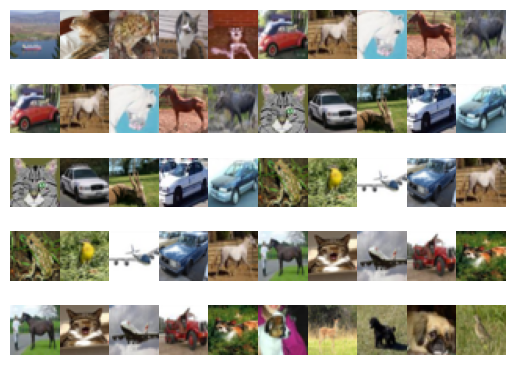

In [39]:
num_samples = 50
rand_inds = np.random.choice(range(40000), num_samples)
# rand_inds = inds[:num_samples]
fig, axs = plt.subplots(5, 10, dpi=100)
for j in range(5):
    for i in range(10):
        axs[j, i].imshow(to_image(train_set[rand_inds[j*5+i]][0]))
        axs[j, i].set_axis_off()
        axs[j, i].set_xticklabels([])
        axs[j, i].set_yticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

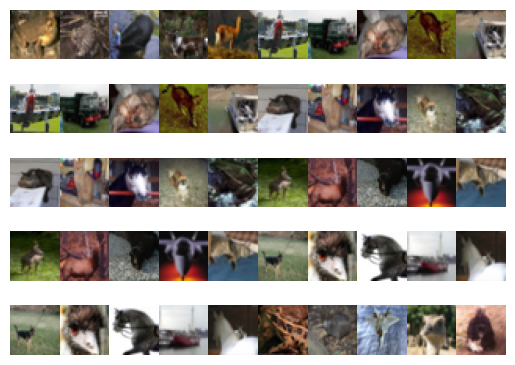

In [40]:
num_samples = 50
# rand_inds = np.random.choice(inds, num_samples)
rand_inds = inds[:num_samples]
fig, axs = plt.subplots(5, 10, dpi=100)
for j in range(5):
    for i in range(10):
        axs[j, i].imshow(to_image(train_set[rand_inds[j*5+i]][0]))
        axs[j, i].set_axis_off()
        axs[j, i].set_xticklabels([])
        axs[j, i].set_yticklabels([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [19]:
np.random.choice

array([22710, 23781, 25764, 37303, 22942, 37222,  5368,  7641, 25038,
        9298])